In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

<h4>Kaggle - Bike Example Linear Regression</h4>
<h5>Training and Test Data: https://www.kaggle.com/c/bike-sharing-demand/data</h5>
<h5>Evaluation: https://www.kaggle.com/c/bike-sharing-demand/details/evaluation</h5>
<h5>Kaggle site requires free registration in order to download the data</h5>

<p>Objective (from Kaggle site):</p>
<ol>
<li>Dataset consists of hourly rental data spanning two years. </li>
<li>Training set is comprised of the first 19 days of each month</li>
<li>Test set is the 20th to the end of the month. </li>
<li>Model should predict the total count of bikes rented during each hour covered by the test set</li>
</ol>

<p>This problem was discussed in AWS Machine Learning resources:
https://blogs.aws.amazon.com/bigdata/post/Tx2OZ63RJ6Z41A0/Building-a-Numeric-Regression-Model-with-Amazon-Machine-Learning
</p>
<p>Strategy:  <br>

We will create two separate Linear Regression models:<br>
1. Casual Rental Prediction<br>
2. Registered Rental Prediction<br>

We will then combine the results to find the total count for submission to Kaggle. Competition is already over, but we can submit to check accuracy of the model.
</p>

<p>Download Train.csv, Test.csv, samplesubmission.csv files from above Kaggle link and store it in C:\AWSMLCourse\Data\RegressionExamples\BikeTrain </p>

<p>This notebook file reads the Train.csv file and creates two separate training files one for registered user rentals and another file for casual user rentals</p>
<p>Following additional features are added: Month, Day, Hour, DayofWeek</p>

<p>Test.csv file is read and additional features are created</p>

Following files are generated:
1. Casual Training - bike_rental_train_casual.csv
2. Registered Training - bike_rental_train_registered.csv
3. Test - bike_rental_test.csv

Following schema files are provided for creating datasource. Copy these schema files to the S3 bucket/folder where you kept the csv training files.
1. bike_rental_train_casual.csv.schema
2. bike_rental_train_registered.csv.schema



In [2]:
data_path = r'C:\AWSMLCourse\Data\RegressionExamples\BikeTrain'

In [3]:
df = pd.read_csv(os.path.join(data_path,'train.csv'), parse_dates=['datetime'])

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# Add some additional features to look at data
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour
df['dayofweek'] = df.datetime.dt.dayofweek  # The day of the week with Monday=0, Sunday=6

In [6]:
df.groupby([df.dayofweek])['casual'].sum()

dayofweek
0     46288
1     35365
2     34931
3     37283
4     47402
5    100782
6     90084
Name: casual, dtype: int64

In [7]:
df.groupby([df.dayofweek])['registered'].sum()

dayofweek
0    249008
1    256620
2    257295
3    269118
4    255102
5    210736
6    195462
Name: registered, dtype: int64

In [8]:
df.casual.describe()

count    10886.000000
mean        36.021955
std         49.960477
min          0.000000
25%          4.000000
50%         17.000000
75%         49.000000
max        367.000000
Name: casual, dtype: float64

In [78]:
df.registered.describe()

count    10886.000000
mean       155.552177
std        151.039033
min          0.000000
25%         36.000000
50%        118.000000
75%        222.000000
max        886.000000
Name: registered, dtype: float64

In [8]:
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,dayofweek
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,0.971524,0.001729,-0.006546,-0.010553
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.001731,-0.015877,-0.000354,-0.191832
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.003394,0.009829,0.002780,-0.704267
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,0.012144,-0.007890,-0.022740,-0.047692
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.257589,0.015551,0.145430,-0.038466
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.264173,0.011866,0.140343,-0.040235
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,0.204537,-0.011335,-0.278011,-0.026507
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.150192,0.036157,0.146631,-0.024804
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.092722,0.014109,0.302045,0.246959
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.169451,0.019111,0.380540,-0.084427


In [9]:
# Pre-shuffle the data for consistency
# Shuffled data would be used for training
np.random.seed(5)
l = list(range(df.shape[0]))
np.random.shuffle(l)

In [10]:
# randomize
df = df.ix[l]

In [11]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,dayofweek
3650,2011-09-03 00:00:00,3,0,0,2,26.24,30.305,73,7.0015,22,65,87,9,3,0,5
8909,2012-08-13 14:00:00,3,0,1,1,32.80,34.850,33,7.0015,85,163,248,8,13,14,0
4623,2011-11-05 17:00:00,4,0,0,1,15.58,19.695,40,11.0014,100,234,334,11,5,17,5
8818,2012-08-09 19:00:00,3,0,1,1,32.80,37.880,55,12.9980,90,533,623,8,9,19,3
1640,2011-04-14 06:00:00,2,0,1,1,13.94,17.425,76,7.0015,4,66,70,4,14,6,3


In [12]:
# Create the following files:
# We need to create two separate models: 
#   Model 1: casual/non-registered users rental count by hour, 
#   Model 2: registered users rental count by hour

# casual users training data
df.to_csv(os.path.join(data_path,'bike_rental_train_casual.csv'), index=False,
columns=['datetime', 'month', 'day', 'hour', 'dayofweek', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual'])

# registered users training data
df.to_csv(os.path.join(data_path,'bike_rental_train_registered.csv'), index=False,
columns=['datetime', 'month', 'day', 'hour', 'dayofweek', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'registered'])

# save all data - for reference
df.to_csv(os.path.join(data_path,'bike_rental_all.csv'), index=False,
columns=['datetime', 'month', 'day', 'hour', 'dayofweek', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'])

In [13]:
# Create the test set with new features
# test set provided by kaggle.
df_test = pd.read_csv(os.path.join(data_path,'test.csv'), parse_dates=['datetime'])
df_test['month'] = df_test.datetime.dt.month
df_test['day'] = df_test.datetime.dt.day
df_test['hour'] = df_test.datetime.dt.hour
df_test['dayofweek'] = df_test.datetime.dt.dayofweek

In [14]:
df_test.to_csv(os.path.join(data_path,'bike_rental_test.csv'), index=False,
columns=['datetime', 'month', 'day', 
         'hour', 'dayofweek', 'season', 'holiday', 
         'workingday', 'weather', 'temp',
         'atemp', 'humidity', 'windspeed'])

In [15]:
df_test.shape

(6493, 13)

In [16]:
df.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [19]:
df.workingday.value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

In [20]:
df.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

<h4>Training and Evaluation Summary</h4>
1. Casual Model:     Training RMSE: 32.69,Eval RMSE: 31.38, Baseline RMSE:  49.21
2. Registered Model: Training RMSE: 92.49,Eval RMSE: 92.28, Baseline RMSE: 149.34

In [19]:
# read predicted values for casual and registered users.
# sum it up and prepare for submission
df_casual_predicted = pd.read_csv(os.path.join(data_path,
                                               'output_casual',
                                               'bp-ya7jyTmM8BQ-bike_rental_test.csv.gz'))

In [20]:
df_casual_predicted.head()

,tag,score
0,2011-01-20 00:00:00,-26.68427
1,2011-01-20 01:00:00,-32.48680
2,2011-01-20 02:00:00,-34.72614
3,2011-01-20 03:00:00,-35.47219
4,2011-01-20 04:00:00,-34.32152


In [21]:
def adjust_score(x):
    if x < 0:
        return 0
    else:
        return x

In [22]:
df_casual_predicted['casual_rental'] = df_casual_predicted.score.map(adjust_score)

In [24]:
df_casual_predicted.tail()

,tag,score,casual_rental
6488,2012-12-31 19:00:00,2.519547,2.519547
6489,2012-12-31 20:00:00,-7.258449,0.000000
6490,2012-12-31 21:00:00,-10.058890,0.000000
6491,2012-12-31 22:00:00,-20.244060,0.000000
6492,2012-12-31 23:00:00,-27.716200,0.000000


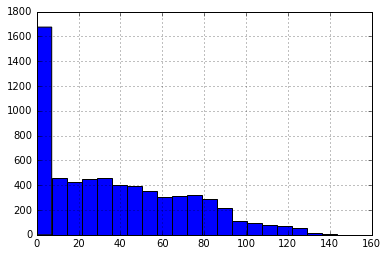

In [25]:
df_casual_predicted.casual_rental.hist(bins=20)

In [26]:
df_registered_predicted = pd.read_csv(os.path.join(data_path,
                                               'output_registered',
                                               'bp-7NxyaOHtgpi-bike_rental_test.csv.gz'))

In [29]:
df_registered_predicted['registered_rental']= df_registered_predicted.score.map(adjust_score)

In [30]:
df_registered_predicted.head()

,tag,score,registered_rental
0,2011-01-20 00:00:00,-3.45234,0.0
1,2011-01-20 01:00:00,-22.35190,0.0
2,2011-01-20 02:00:00,-28.86697,0.0
3,2011-01-20 03:00:00,-20.51039,0.0
4,2011-01-20 04:00:00,-19.89263,0.0


In [31]:
df_registered_predicted.registered_rental.describe()

count    6493.000000
mean      157.724648
std       119.087736
min         0.000000
25%        56.622060
50%       146.798200
75%       231.875700
max       504.412900
Name: registered_rental, dtype: float64

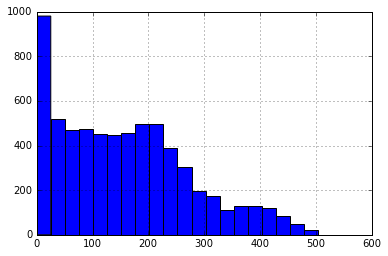

In [32]:
df_registered_predicted.registered_rental.hist(bins=20)

In [33]:
df_registered_predicted["casual_rental"] = df_casual_predicted.casual_rental

In [34]:
df_registered_predicted['count'] = \
df_registered_predicted.registered_rental + df_registered_predicted.casual_rental

In [35]:
df_registered_predicted.tail()

,tag,score,registered_rental,casual_rental,count
6488,2012-12-31 19:00:00,252.35810,252.35810,2.519547,254.877647
6489,2012-12-31 20:00:00,178.92700,178.92700,0.000000,178.927000
6490,2012-12-31 21:00:00,142.05790,142.05790,0.000000,142.057900
6491,2012-12-31 22:00:00,73.63227,73.63227,0.000000,73.632270
6492,2012-12-31 23:00:00,48.55751,48.55751,0.000000,48.557510


In [36]:
df_registered_predicted.columns = ['datetime','score','registered_rental','casual_rental','count']

In [37]:
df_registered_predicted.tail()

,datetime,score,registered_rental,casual_rental,count
6488,2012-12-31 19:00:00,252.35810,252.35810,2.519547,254.877647
6489,2012-12-31 20:00:00,178.92700,178.92700,0.000000,178.927000
6490,2012-12-31 21:00:00,142.05790,142.05790,0.000000,142.057900
6491,2012-12-31 22:00:00,73.63227,73.63227,0.000000,73.632270
6492,2012-12-31 23:00:00,48.55751,48.55751,0.000000,48.557510


In [38]:
df_registered_predicted.to_csv(os.path.join(data_path,
                                            'predicted_test_1.csv'),index=False,
                              columns=['datetime','count'])

In [76]:
# Above file is now in the format suitable for submission to Kaggle